In [1]:
import os
import time

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

import cartopy.crs as ccrs
import cartopy.feature as cf

from tqdm import tqdm

from scipy.stats import linregress, pearsonr

# Mask

In [2]:
mask = xr.load_dataset('./GFED_basis_regions_025.nc')

# Data

In [3]:
DS = xr.open_dataset("./GFED4_FBA.nc")
FBA_test = DS.data_vars['Fraction_of_BurntArea'].sel(time=slice('2001-01-01','2015-12-31'))
FBA_test = FBA_test.fillna(0)

# Model results

In [4]:
DS_ = xr.open_dataset("./JSB4_simple_025.nc")
FBA_results = DS_.data_vars['burned_fract_box'].sel(time=slice('2001-01-01','2015-12-31'))
print(FBA_results.shape)

(5478, 720, 1440)


# Timeseries

In [5]:
def monthly_plot(y, yhat, region, R2, Corr):
    plt.figure(figsize=(8,3))
    (y).plot(label='FBA', color='black')
    (yhat).plot(label='estimated', color='blue')

    plt.title(f'GFED {region} (R2: {R2:.3f}, Corr: {Corr:.3f})', fontsize=15)
    plt.legend(fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()
    return

In [6]:
def yearly_plot(y, yhat, region, R2, Corr):
    plt.figure(figsize=(5,3))
    (y).plot(label='FBA', color='black')
    (yhat).plot(label='estimated', color='blue')

    plt.title(f'GFED {region} (R2: {R2:.3f}, Corr: {Corr:.3f})', fontsize=15)
    plt.legend(fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()
    return

In [7]:
def daily_plot(y, yhat, region, R2, Corr):
    plt.figure(figsize=(20,5))
    (y).plot(label='FBA', color='black')
    (yhat).plot(label='estimated', color='blue')

    plt.title(f'{region} (R2: {R2:.3f}, Corr: {Corr:.3f})', fontsize=30)
    plt.legend(fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    return

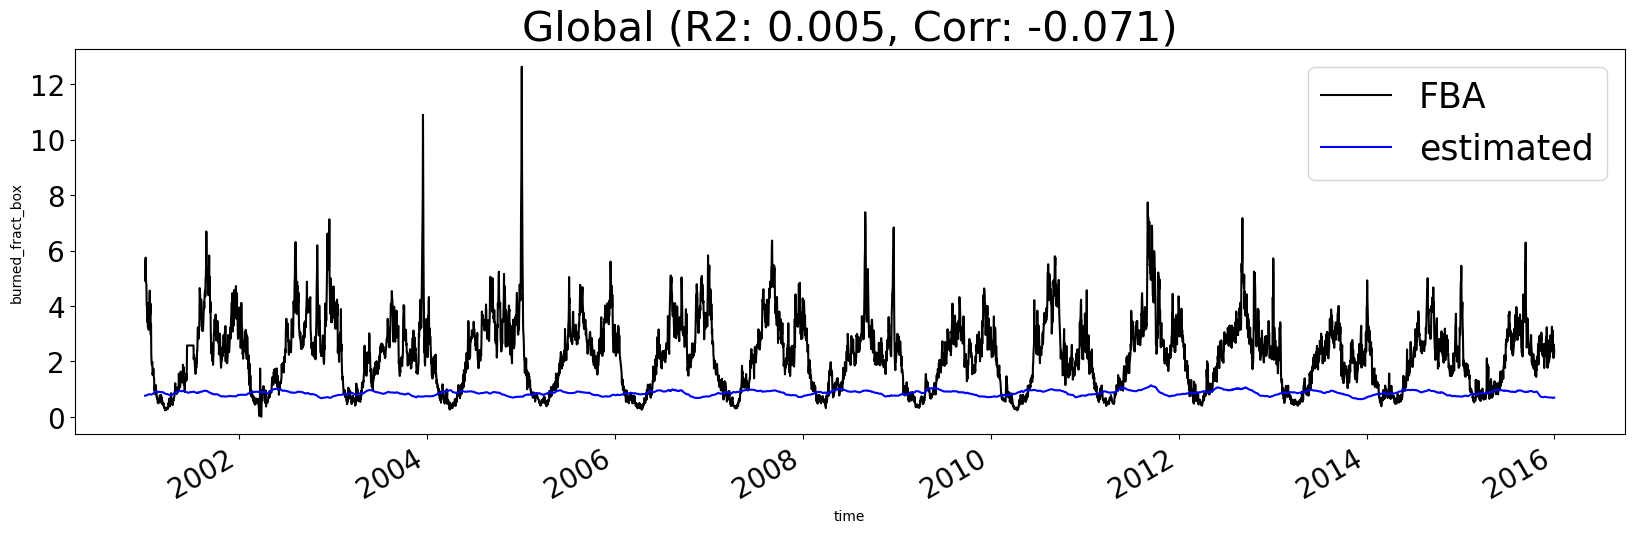

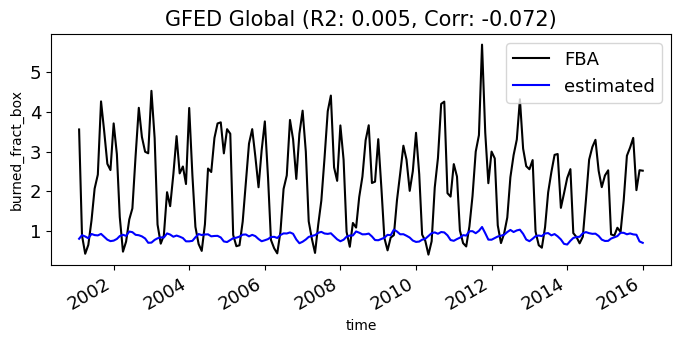

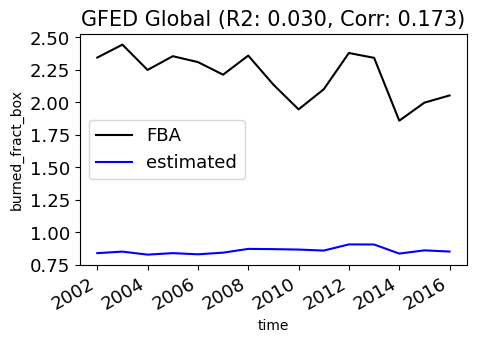

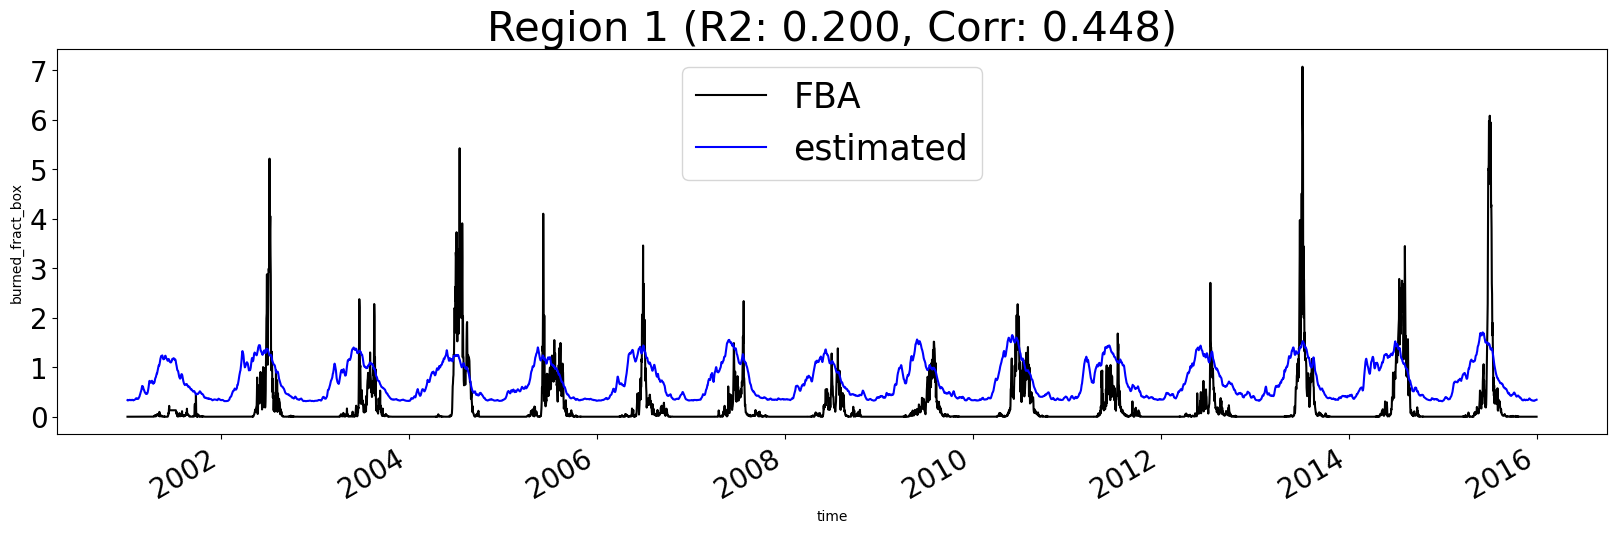

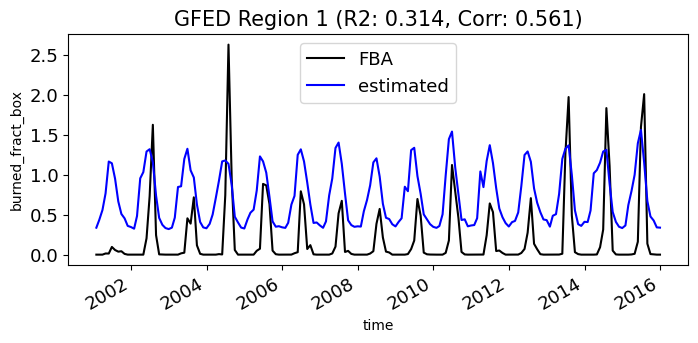

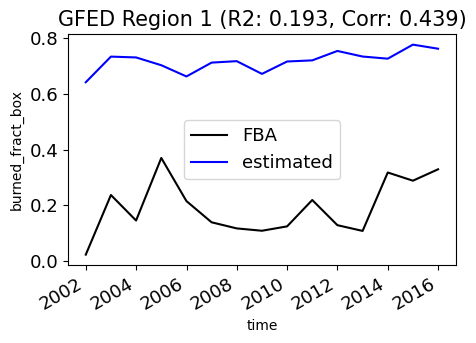

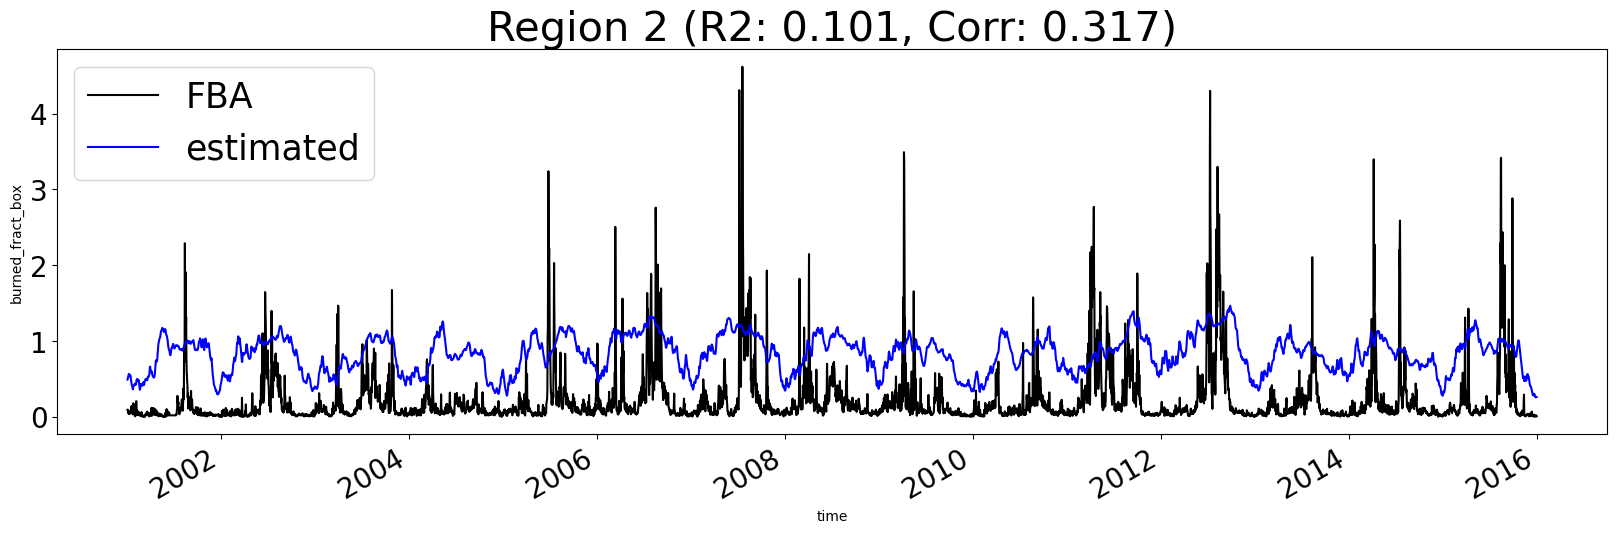

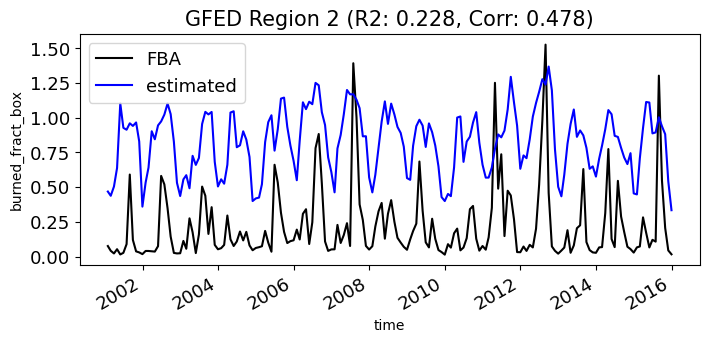

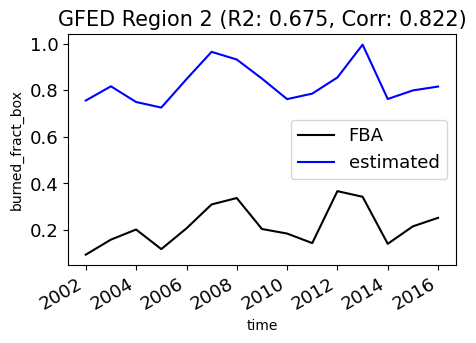

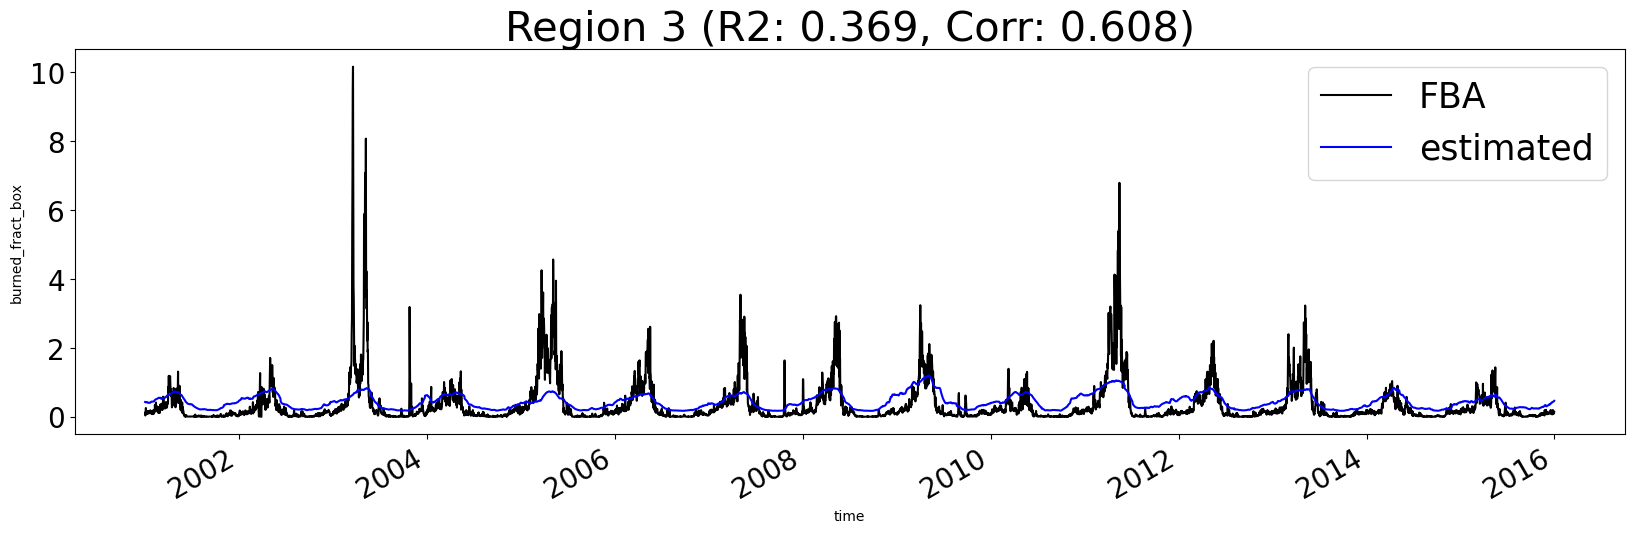

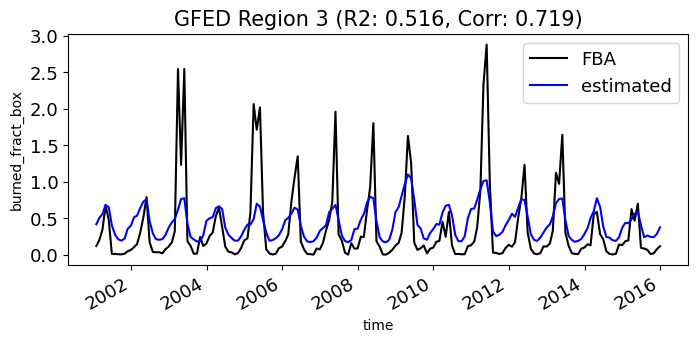

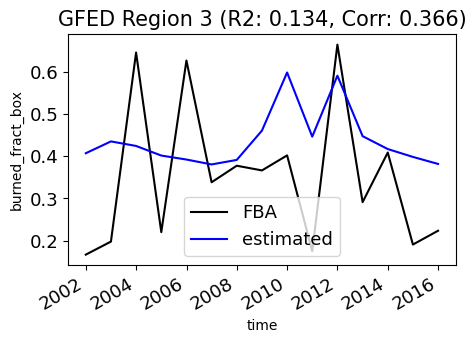

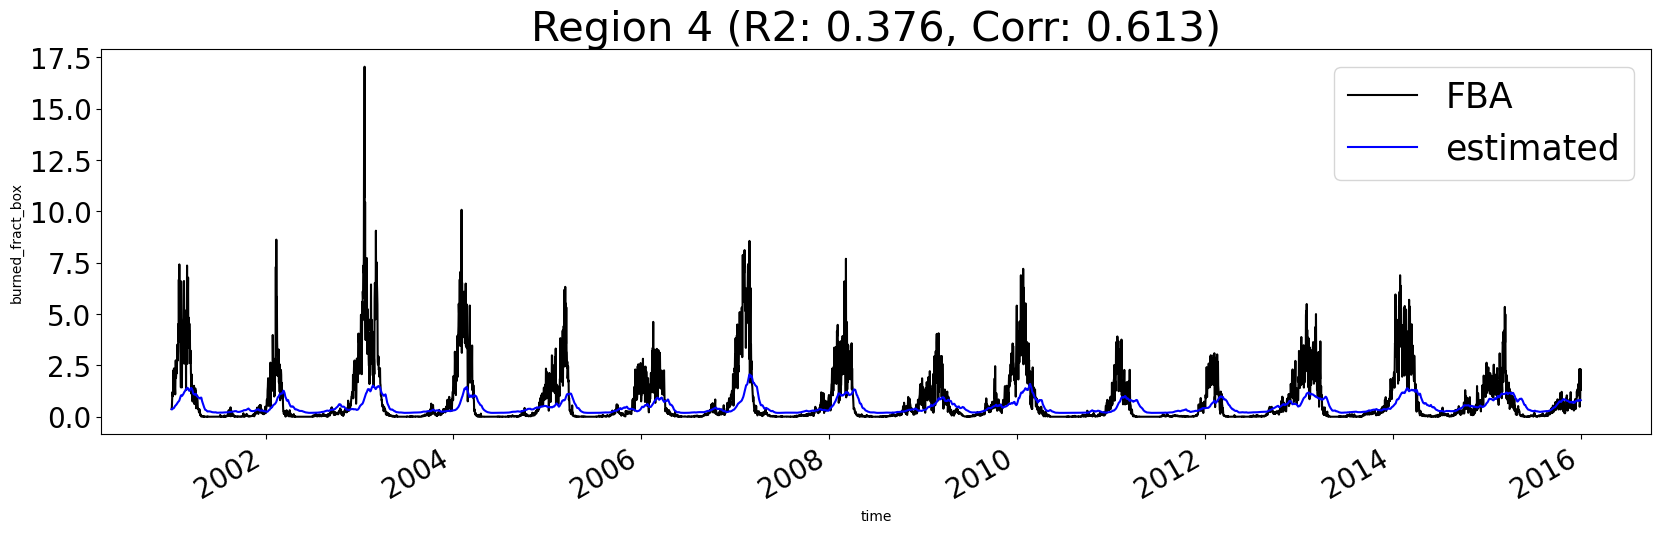

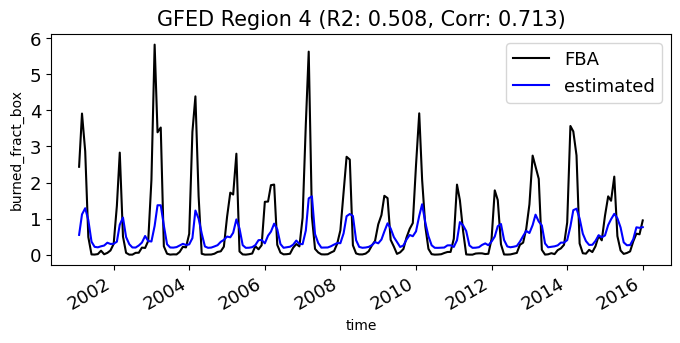

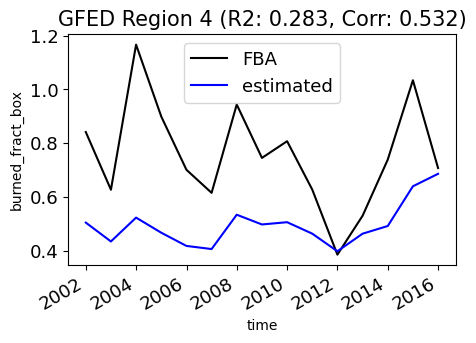

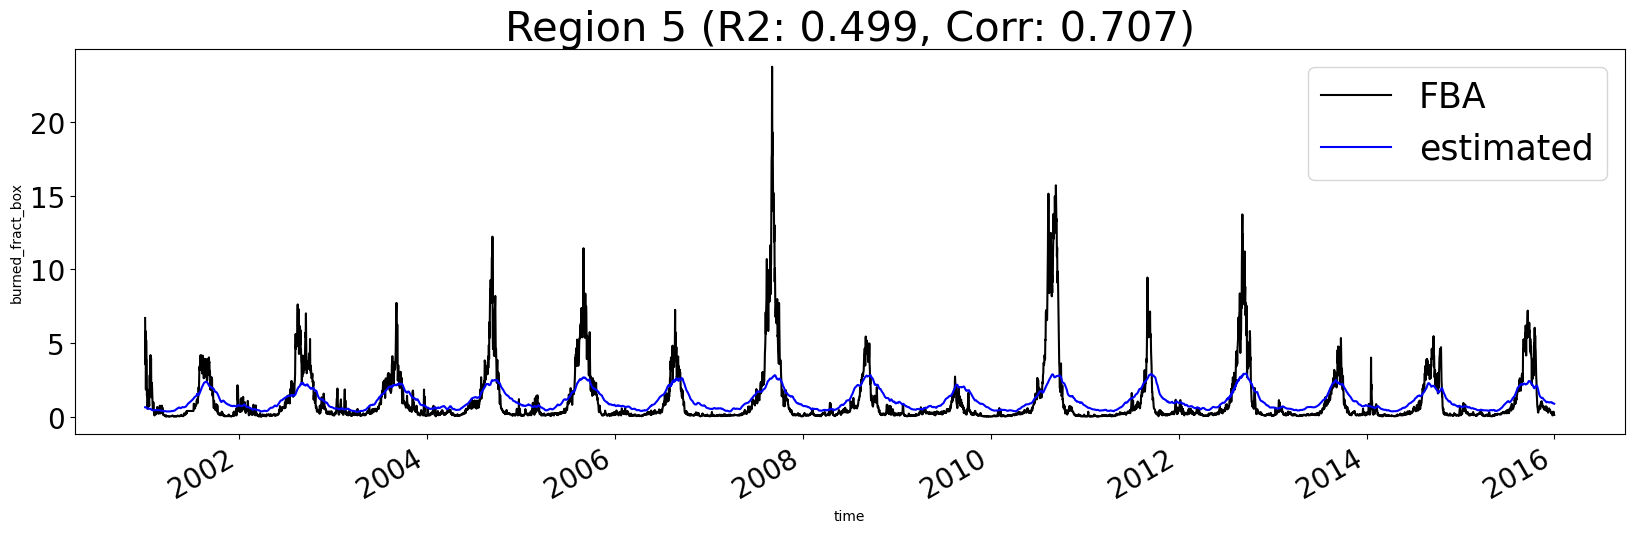

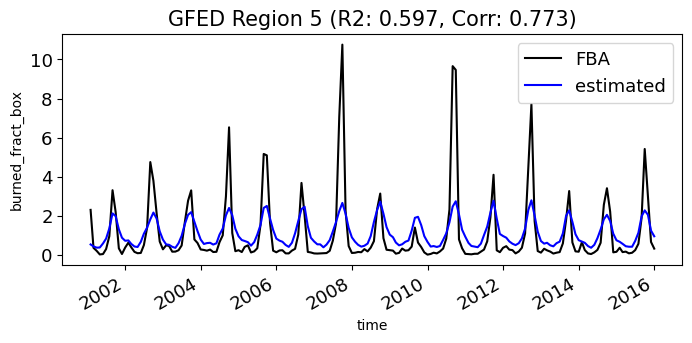

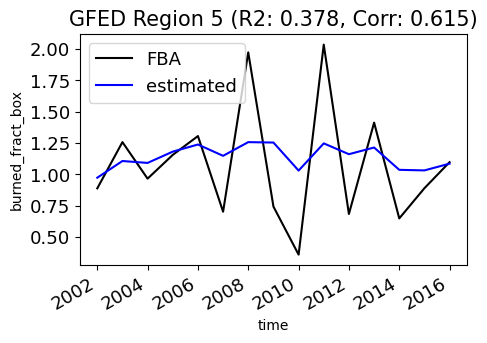

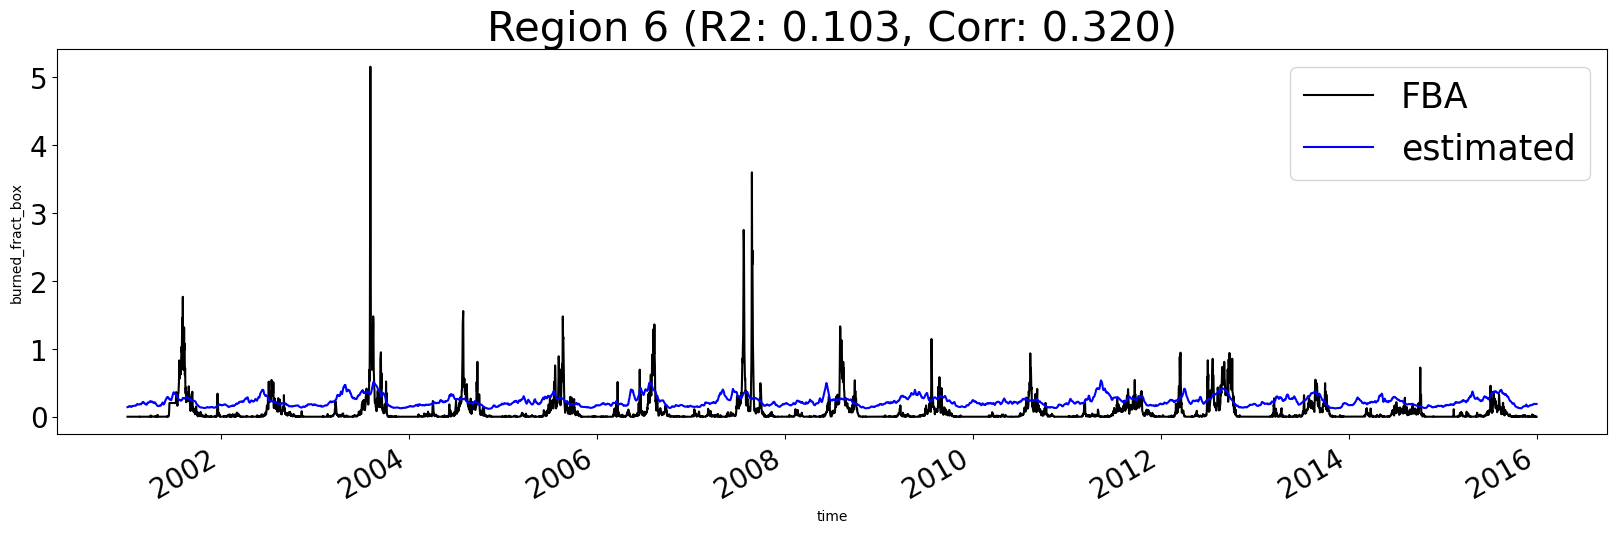

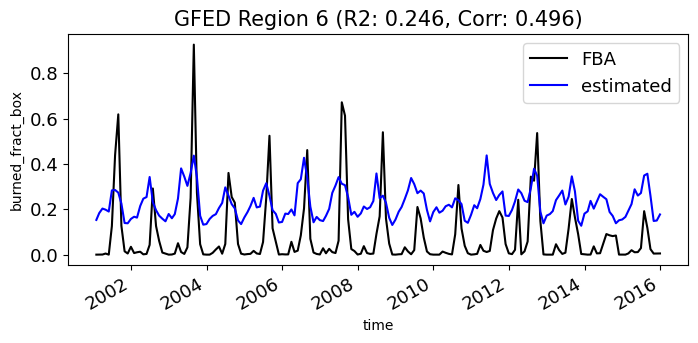

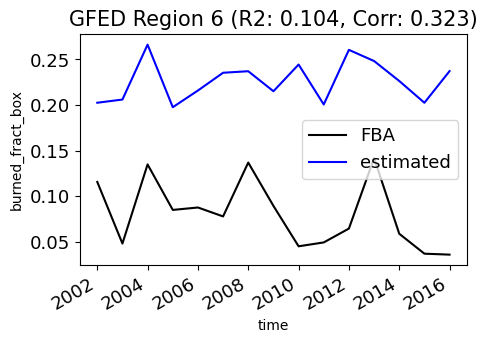

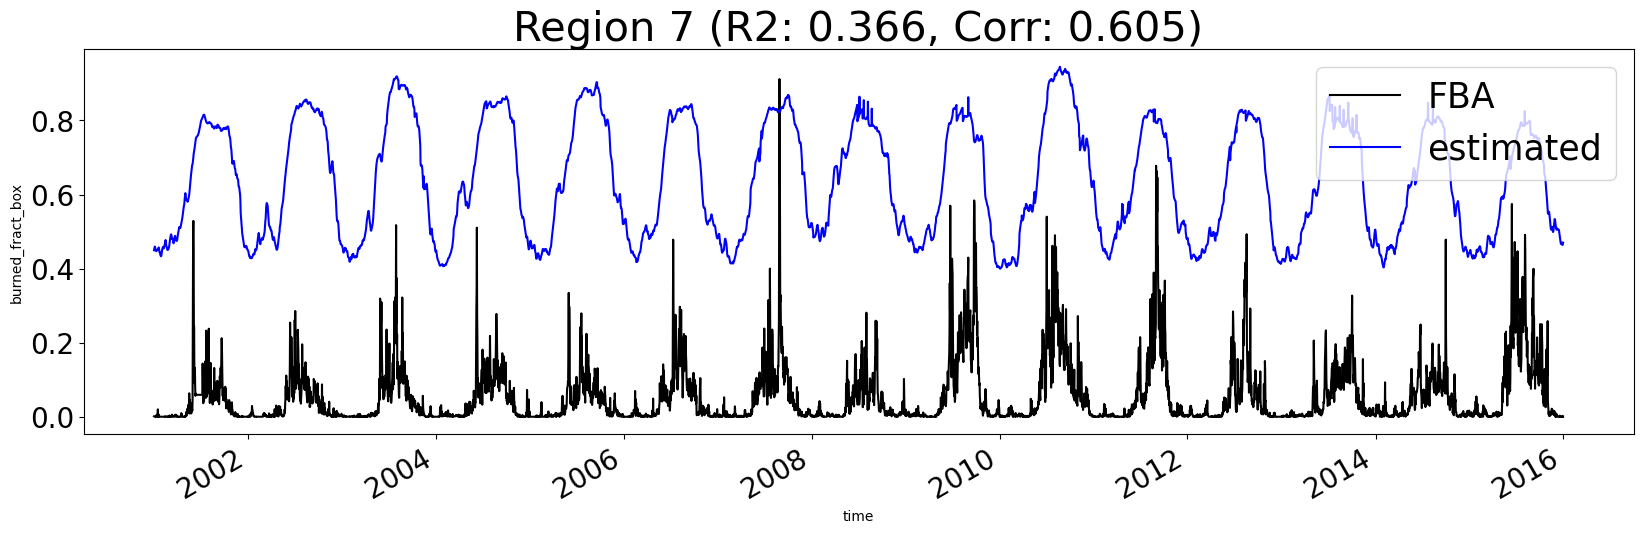

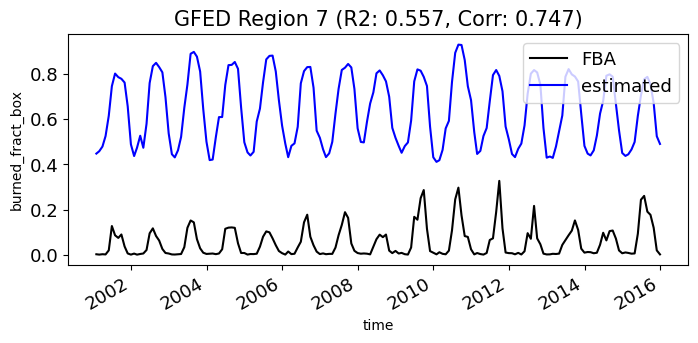

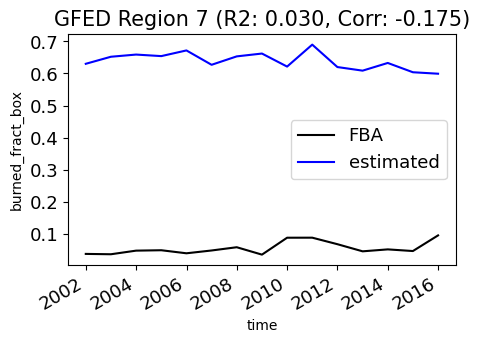

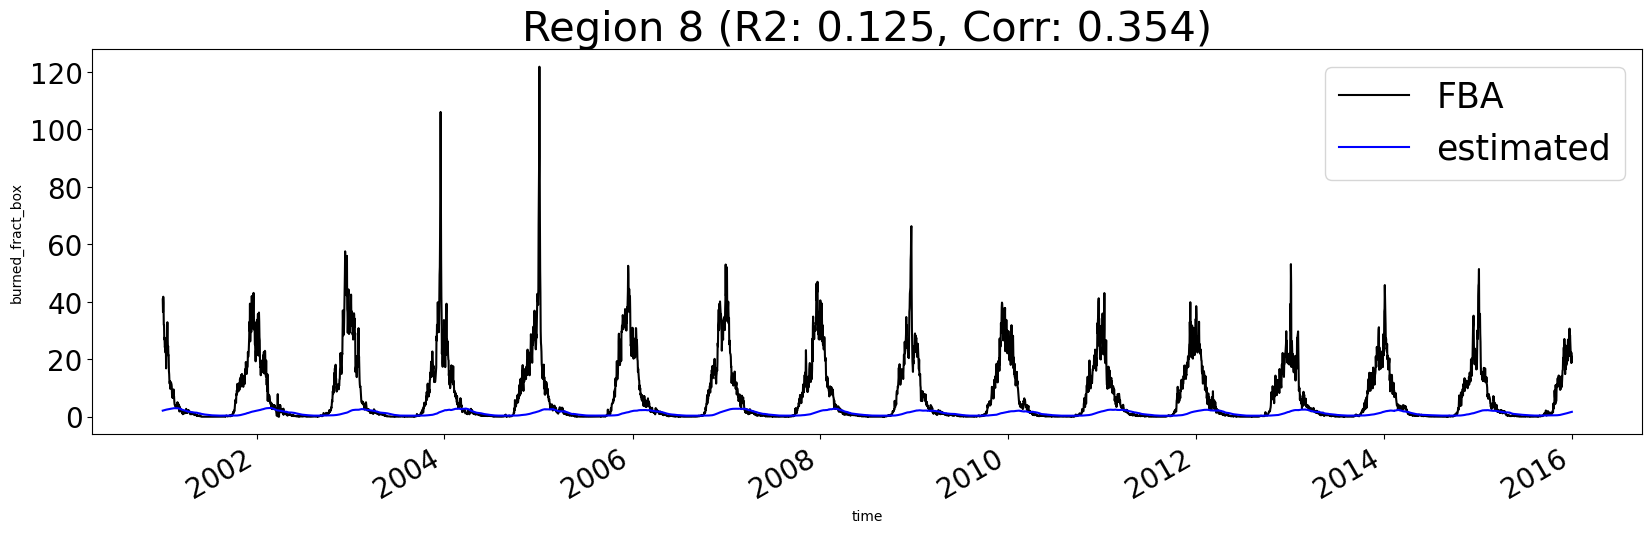

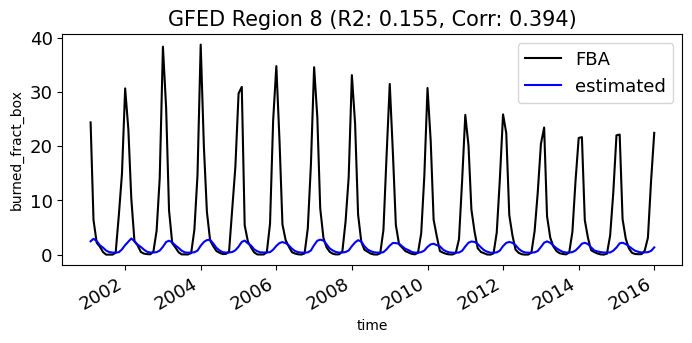

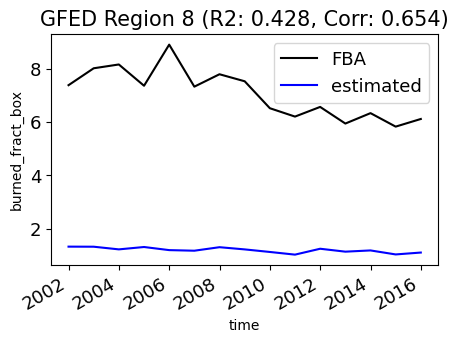

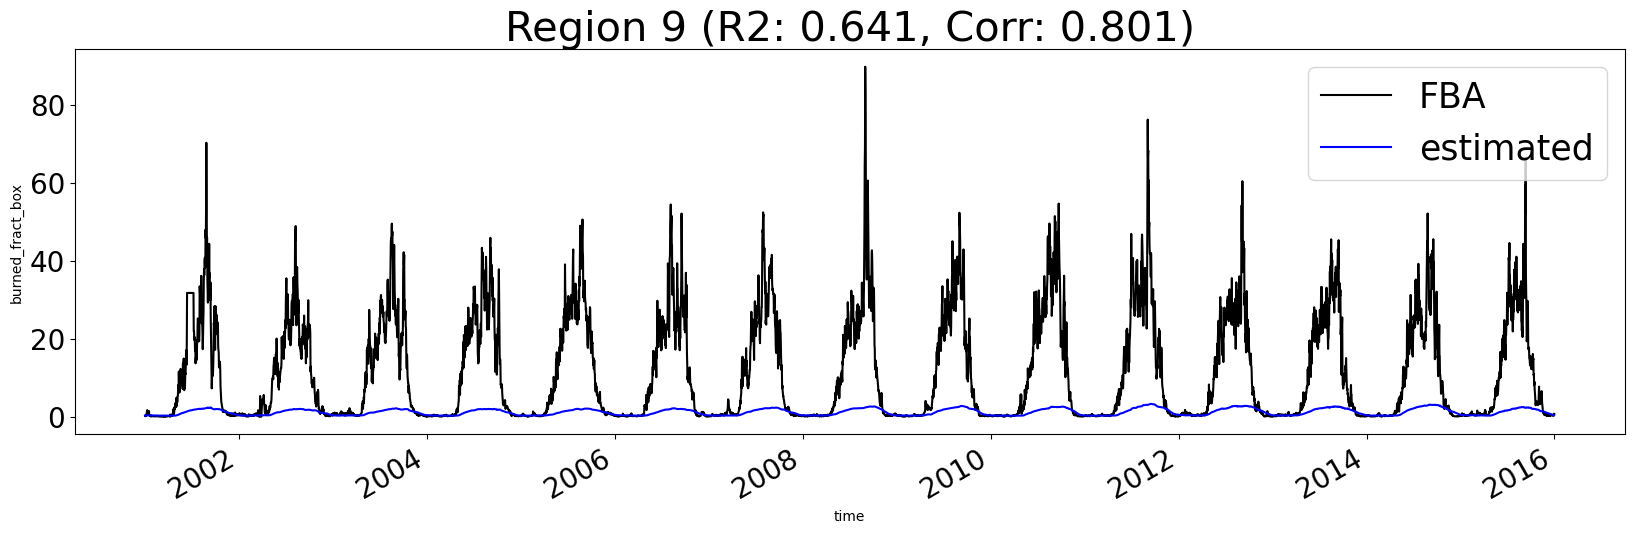

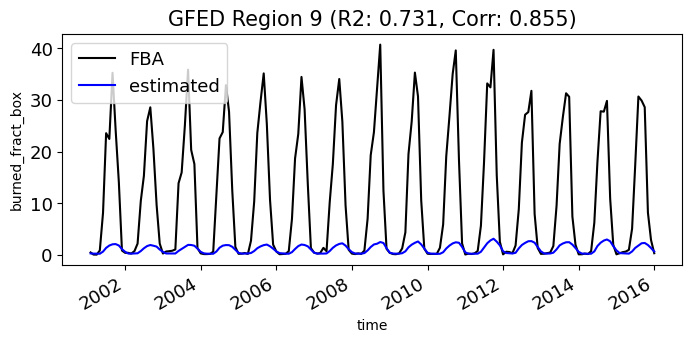

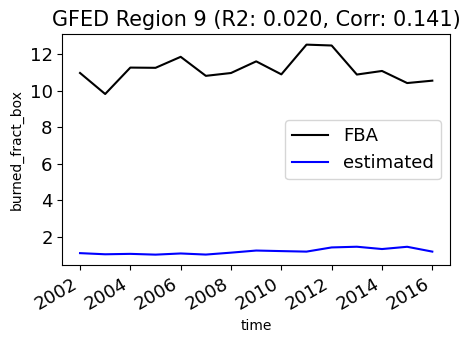

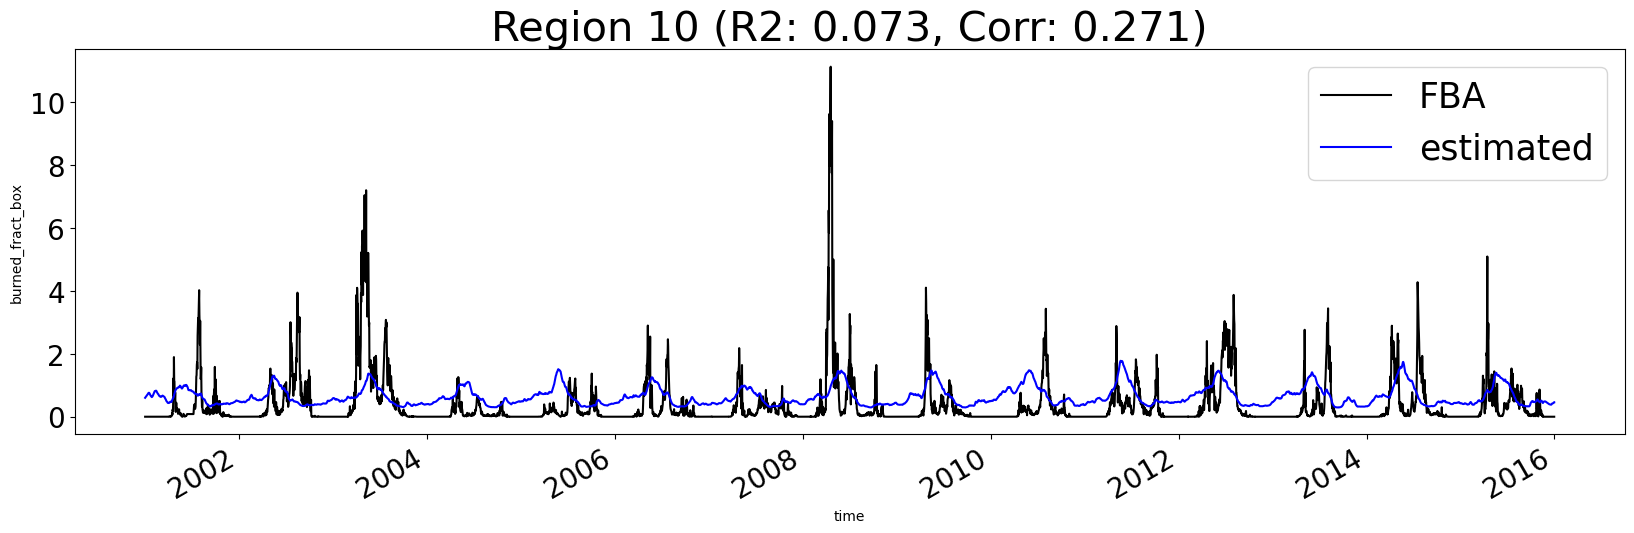

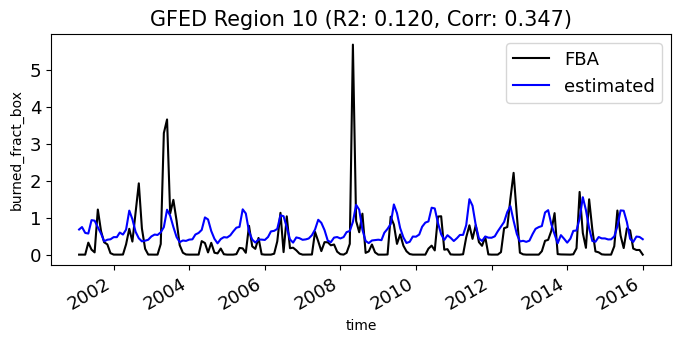

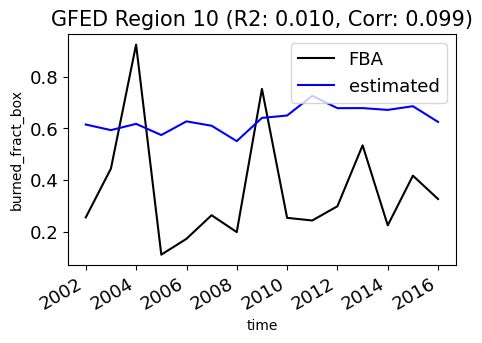

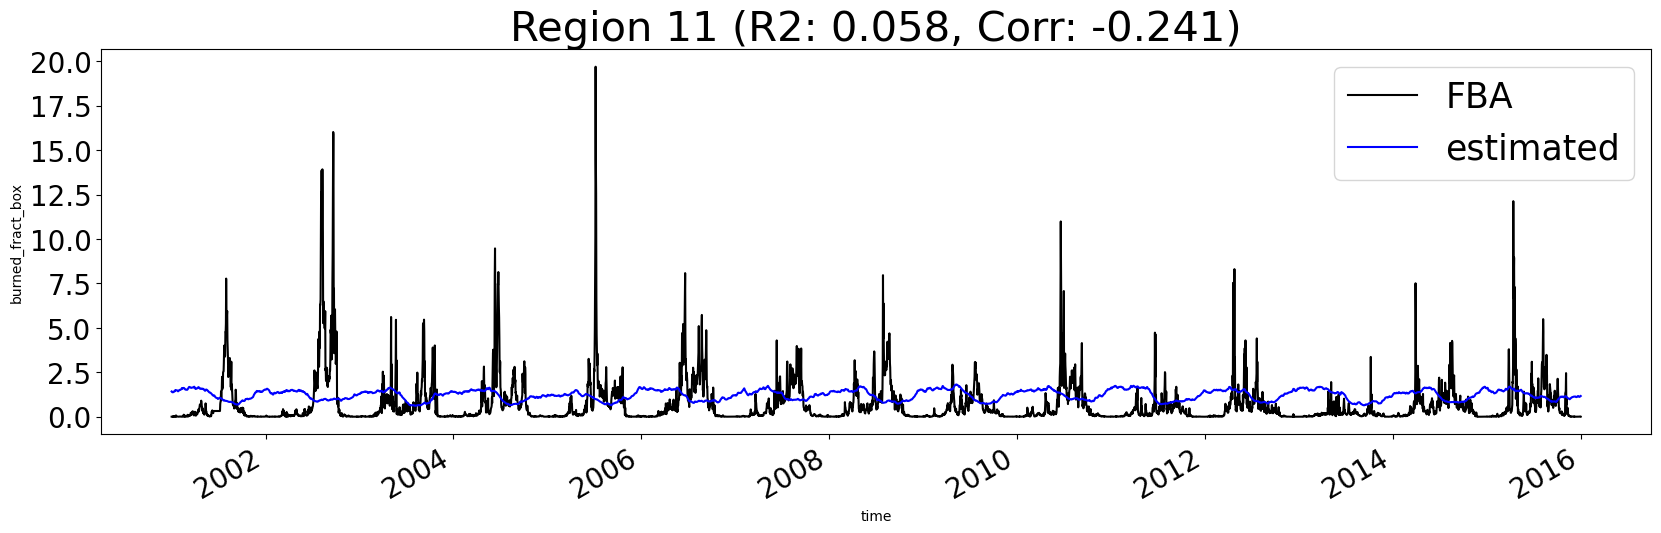

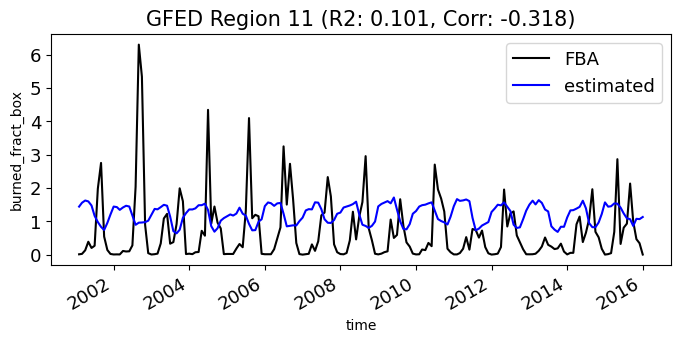

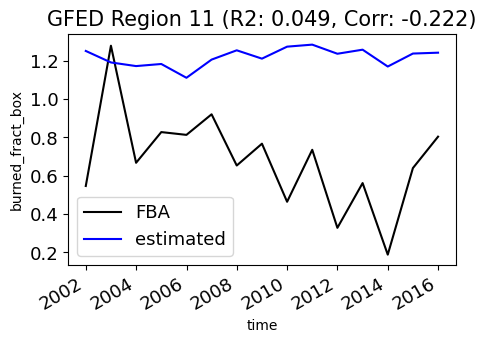

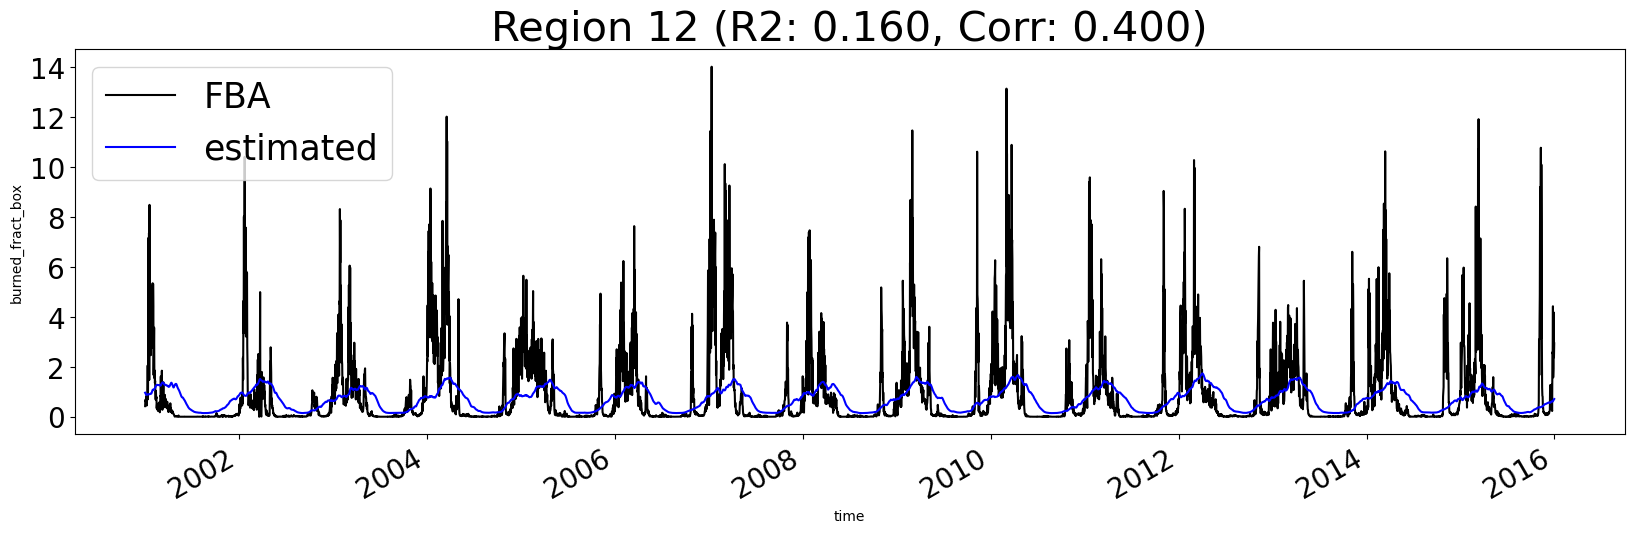

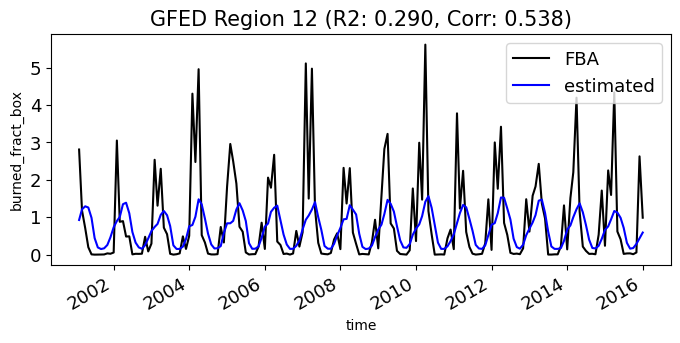

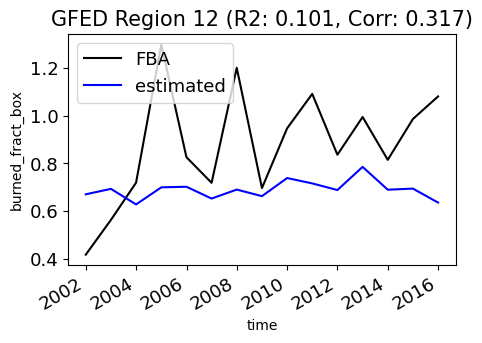

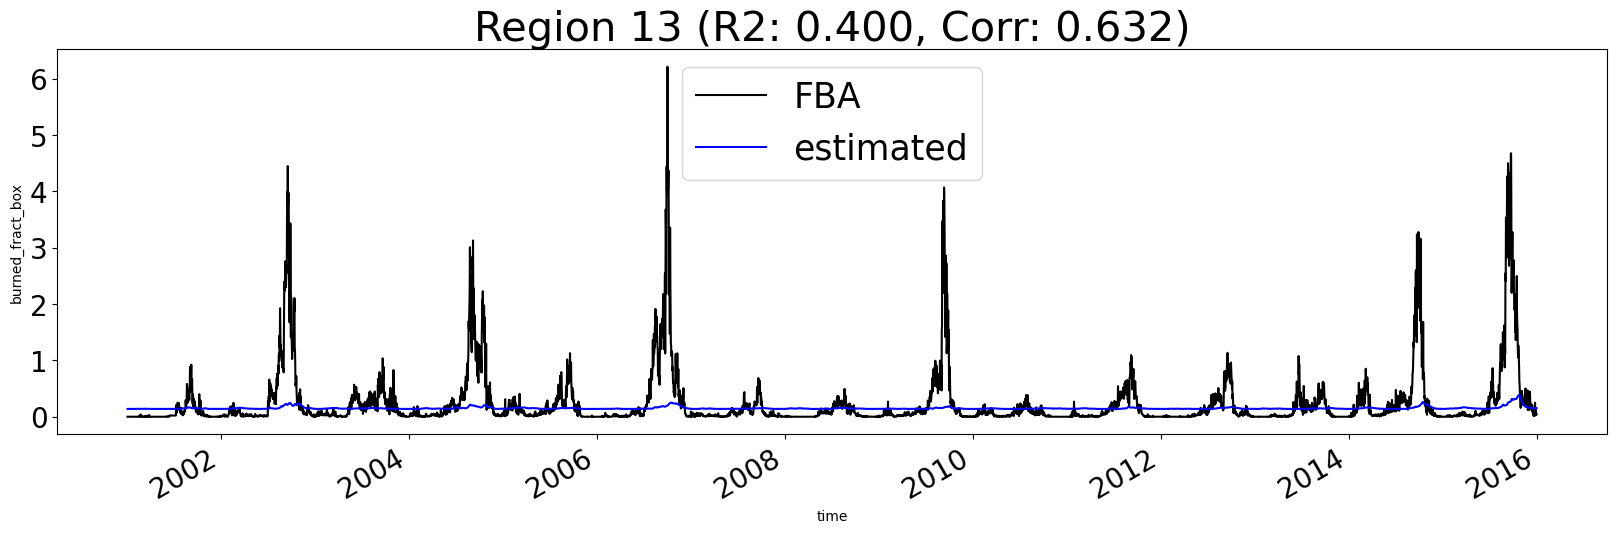

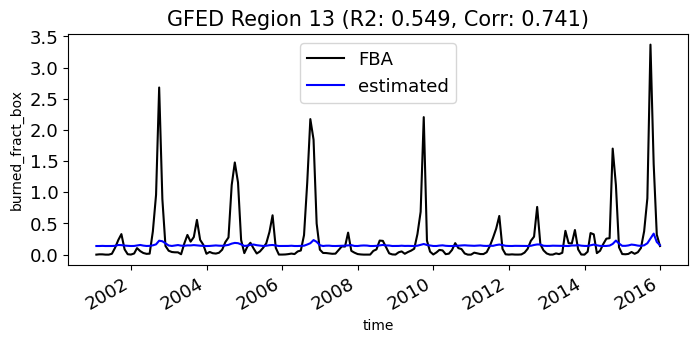

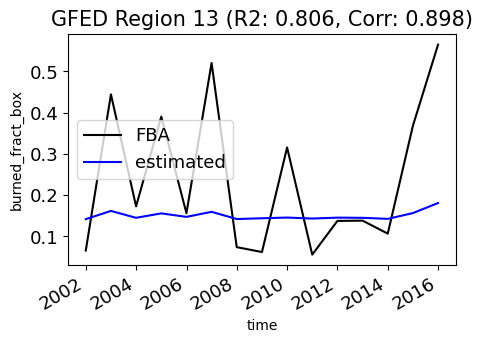

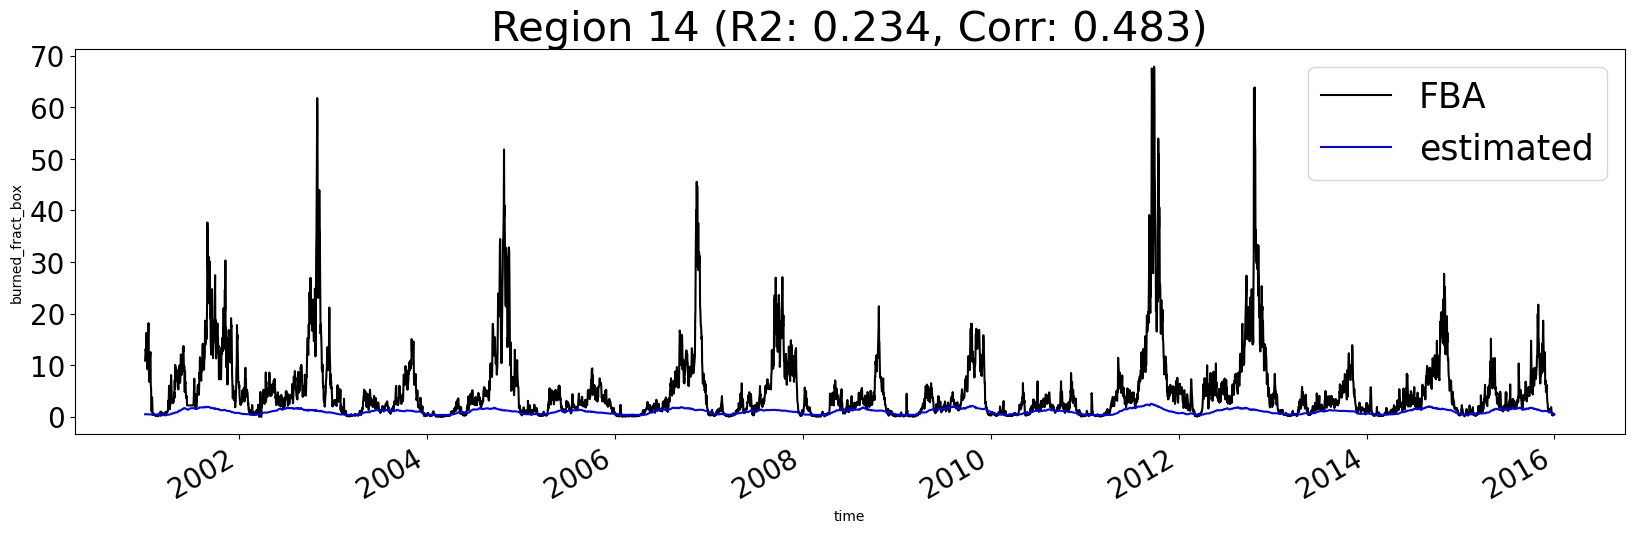

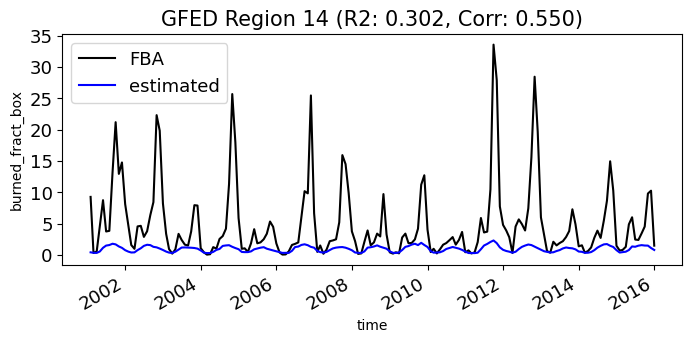

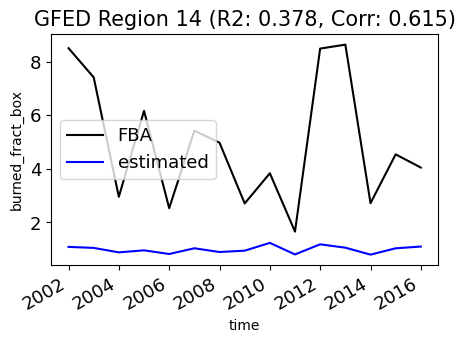

In [8]:
for i in range(15):
    if i == 0:
        FBA_o = FBA_test.where(mask['region']>0)*100*365
        FBA_m = FBA_results.where(mask['region']>0)*100*365
        region_name = 'Global'
    else:
        FBA_o = FBA_test.where(mask['region']==i)*100*365
        FBA_m = FBA_results.where(mask['region']==i)*100*365
        region_name = f'Region {i}'

    weights = np.cos(np.deg2rad(FBA_o.lat))
    weights.name = "weights"

    daily_o = FBA_o.weighted(weights).mean(("lon", "lat"))
    daily_m = FBA_m.weighted(weights).mean(("lon", "lat"))

    _, _, r_value, _, _ = linregress(daily_o.to_numpy(), daily_m.to_numpy())
    r2_daily = r_value**2
    corr_daily, _ = pearsonr(daily_o.to_numpy(), daily_m.to_numpy())
    daily_plot(daily_o, daily_m, region_name, r2_daily, corr_daily)

    monthly_o = daily_o.resample(time='1M').mean()
    monthly_m = daily_m.resample(time='1M').mean()

    _, _, r_value, _, _ = linregress(monthly_o.to_numpy(), monthly_m.to_numpy())
    r2_monthly = r_value**2
    corr_monthly, _ = pearsonr(monthly_o.to_numpy(), monthly_m.to_numpy())
    monthly_plot(monthly_o, monthly_m, region_name, r2_monthly, corr_monthly)

    yearly_o = daily_o.resample(time='1Y').mean()
    yearly_m = daily_m.resample(time='1Y').mean()

    _, _, r_value, _, _ = linregress(yearly_o.to_numpy(), yearly_m.to_numpy())
    r2_yearly = r_value**2
    corr_yearly, _ = pearsonr(yearly_o.to_numpy(), yearly_m.to_numpy())
    yearly_plot(yearly_o, yearly_m, region_name, r2_yearly, corr_yearly)